# 파이썬 기반의 AI를 위한 기초수학, 확률및통계

In [1]:
## 강봉주 
## bonjour.kang@gmail.com
##
## 다중 선형회귀분석
##

In [2]:
# 필요한 패키지
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import scipy
from scipy import linalg as la
import scipy.stats as ss
import scipy.special

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지 2
import statsmodels.formula.api as smf
import statsmodels.api as sm

sm.__version__

'0.10.1'

In [3]:
# 데이터 구성: [HOUSING]
# 경로 정의
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(url,sep='\s+',  header=None)

# 컬럼 정보 주기
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
              'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns = df.columns.str.lower()

# 데이터 확인
df.shape

(506, 14)

## 모수의 추정

In [4]:
# 표본 크기
size = 100

# 씨앗값 정의
np.random.seed(123)
index = np.random.choice(np.arange(len(df)), size=size, replace=False)

# 표본 구성
xvars = ['rm', 'age', 'lstat']
target ='medv'
sdf = df.loc[index, xvars+[target]]
sdf.shape

(100, 4)

In [5]:
# 1 벡터를 추가하는 방법
X = sdf[xvars]
X = np.concatenate(((np.ones(len(X))[:, np.newaxis]), X),  axis=1)

In [6]:
## QR 분해를 통한 모수의 추정
X = sdf[xvars]
X = sm.add_constant(X).values
y = sdf[target].values
Q, R = la.qr(X.T@X)

beta = la.inv(R) @ Q.T @ X.T @ y
beta.round(3)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


array([ 1.3063e+01,  2.9310e+00,  3.0000e-03, -7.1100e-01])

In [7]:
## statsmodels 에 의한 모수의 추정
# 기호식 구성
fmla = target + '~' + '+'.join(xvars)
fmla

'medv~rm+age+lstat'

In [8]:
# 적합
fit = smf.ols(fmla, data=sdf).fit()
fit.params.round(3)

Intercept    13.063
rm            2.931
age           0.003
lstat        -0.711
dtype: float64

## 오차 분산의 추정

In [9]:
# 직접 계산
H = X @ la.inv(X.T @ X) @ X.T
n = H.shape[0]
p = 1 + 3
I = np.identity(n)
MSE = 1/(n - p) * y.T @ (I-H) @ y
MSE.round(3)

41.496

In [10]:
# 결과 확인
fit.mse_resid.round(3)

41.496

## 모수의 추론

In [11]:
# 검정 통계량 계산
beta_hat = la.inv(X.T @ X) @ X.T @ y
D = np.sqrt(la.inv(X.T @ X))

t_zero = beta_hat[:, np.newaxis] / (np.diag(D).reshape(-1, 1) * np.sqrt(MSE))
t_zero

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 1.40846797],
       [ 2.20709057],
       [ 0.08976109],
       [-4.61866789]])

In [12]:
# 결과 확인
fit.tvalues

Intercept    1.408468
rm           2.207091
age          0.089761
lstat       -4.618668
dtype: float64

In [13]:
# p-values 계산
pvalue = 2*(1 - ss.t.cdf(np.abs(t_zero), df=n-p))
pvalue

array([[1.62223028e-01],
       [2.96907987e-02],
       [9.28664075e-01],
       [1.19892794e-05]])

In [14]:
# 결과 확인
fit.pvalues

Intercept    0.162223
rm           0.029691
age          0.928664
lstat        0.000012
dtype: float64

## 회귀직선의 유의성 검증

In [15]:
# 변수 정의
xvars = ['rm', 'age', 'lstat']
target ='medv'

# 자유도 정의
n = len(sdf)
p = len(xvars) +1
[n, p]

[100, 4]

In [16]:
# 제곱합 계산
y = sdf[target]
SSE = np.sum((y - fit.fittedvalues)**2)
SST = np.sum((y - np.mean(y))**2)
SSR = SST - SSE

MSE = SSE / (n-p)
MSR = SSR / (p-1)
np.round([MSE, MSR], 3)

array([  41.496, 1468.649])

In [17]:
#  F 값 계산
f_zero = MSR/MSE

# p-value 계산
pvalue = 1 - ss.f.cdf(f_zero, dfn=p-1, dfd=n-p)

np.round([f_zero, pvalue], 3)

array([35.392,  0.   ])

In [18]:
# 결과 확인
np.round([fit.fvalue, fit.f_pvalue], 3)

array([35.392,  0.   ])

## 오차 가정 검증

### 모자 행렬의 성질

In [19]:
# 모자 행렬의 생성
H = X @ la.inv(X.T@X) @ X.T
H.shape

(100, 100)

In [20]:
# 성질 확인
n  = len(H)

# 모두 1/n 보다 크거나 같고 1보다 작거나 같은가?
np.sum((np.diag(H) >= 1/n) & (np.diag(H)<= 1) )

100

In [21]:
# 대각원소를 제외한 모든 원소가 -0.5와 0.5사이에 있는가?
diag_zero_H = H.copy()
np.fill_diagonal(diag_zero_H, 0)

# 전체 원소가 참
np.sum((diag_zero_H >= -0.5) & (diag_zero_H <= 0.5))

10000

In [22]:
# 대각합은 변수의 개수 +1 인가?
np.trace(H).round()

4.0

In [23]:
# n, p 정의
n = H.shape[0]
p = 4

# 잔차, MSE 계산
I = np.identity(n)
resid = (I - H) @ y
mse = resid.T @ resid / (n-p)
h_diag = np.diag(H)

# 표준화 잔차 계산
t = resid / (np.sqrt(mse) * np.sqrt(1 - h_diag))
t[:2].round(3)

array([-1.289, -0.219])

In [24]:
# 적합 모델에서 영향점, 이상점 분석을 위한 인스턴스 정의
rdg = fit.get_influence()

# 표준화 잔차 결과 확인
rdg.resid_studentized[:2].round(3)

array([-1.289, -0.219])

## 이상점 판정

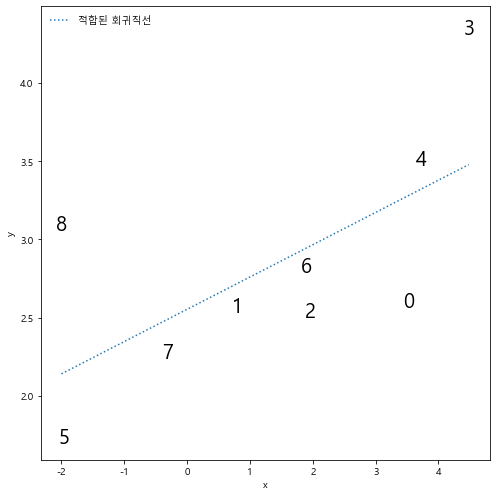

In [25]:
# 데이터 구성
np.random.seed(0)
x = np.random.normal(scale=2, size=8)
x = np.concatenate([x, [-2]])
y = 2 + 0.2*x + np.random.normal(size=9)

# 적합
sfit = sm.OLS(y, sm.add_constant(x)).fit()

# 그래프 표현
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y, color='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
miny = sfit.predict([1, np.min(x)])
maxy = sfit.predict([1, np.max(x)])
ax.plot([np.min(x),np.max(x)], [miny, maxy], ls='dotted', label='적합된 회귀직선')
for i, (x1, y1) in enumerate(zip(x, y)):
    ax.annotate(str(i), (x1, y1), ha='center', va='center', fontsize=20)

plt.legend(frameon=False)

plt.tight_layout()

In [26]:
# 이상점 파악
print(sfit.get_influence().summary_frame()[['standard_resid','student_resid']])

   standard_resid  student_resid
0       -1.256752      -1.322216
1       -0.258594      -0.240563
2       -0.737492      -0.710964
3        1.739347       2.137032
4        0.344098       0.321302
5       -0.851857      -0.833026
6       -0.212793      -0.197648
7       -0.392486      -0.367437
8        1.945842       2.658769


In [27]:
# 예제: 이상점 찾기

# 표준화 잔차
rdg = fit.get_influence()
t = rdg.resid_studentized

# 조건 충족하는 경계값 찾기
alpha = 0.05
cutoff = np.quantile(np.abs(t), q=1-alpha)

# 해당 관측값 찾기
sig_index = np.where(t >= cutoff)
# sig_index
sdf.iloc[sig_index]

,rm,age,lstat,medv
372,5.875,89.6,8.88,50.0
369,6.683,96.8,3.73,50.0
162,7.802,98.2,1.92,50.0
374,4.138,100.0,37.97,13.8


## 영향점 판정

In [28]:
# 지렛대 경계값 구하기
k = 1
n = 9
lvg_cut = 2*(k+1)/n
np.round(lvg_cut, 3)

0.444

In [29]:
# 지렛대 값 계산
lvg = sfit.get_influence().summary_frame()['hat_diag']
lvg.round(3)

0    0.214
1    0.118
2    0.119
3    0.324
4    0.235
5    0.348
6    0.118
7    0.170
8    0.355
Name: hat_diag, dtype: float64

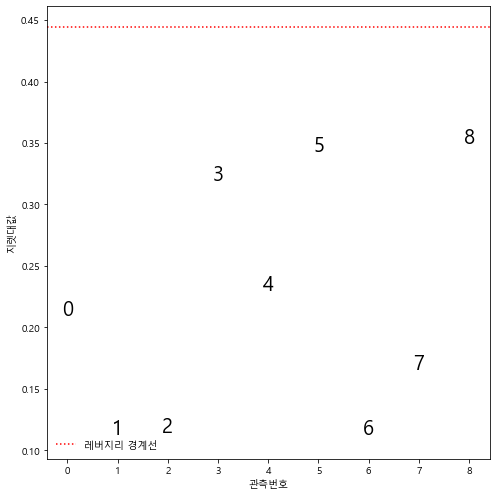

In [30]:
# 그래프 표현
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(np.arange(n), lvg, color='none')
ax.set_xlabel('관측번호')
ax.set_ylabel('지렛대값')

for i, (x1, y1) in enumerate(zip(np.arange(n), lvg)):
    ax.annotate(str(i), (x1, y1), ha='center', va='center', fontsize=20)

ax.axhline(y=lvg_cut, ls=':',color='red', label='레버지리 경계선')

plt.legend(frameon=False)
plt.tight_layout()

In [31]:
# 쿡의 거리
cooks_d = sfit.get_influence().summary_frame()['cooks_d']
cooks_d.round(3)

0    0.215
1    0.004
2    0.037
3    0.725
4    0.018
5    0.194
6    0.003
7    0.016
8    1.040
Name: cooks_d, dtype: float64

In [32]:
# 쿡의 거리 계산 

# n, p 정의
n = sdf.shape[0]
p = sdf.shape[1]

# X, y 행렬 정의
X = sdf[xvars]
X = sm.add_constant(X).values
y = sdf[target].values

# 모자 행렬의 생성
H = X @ la.inv(X.T@X) @ X.T
H.shape

# 잔차, MSE 계산
I = np.identity(n)
resid = (I - H) @ y
mse = resid.T @ resid / (n-p)
h_diag = np.diag(H)

# 표준화 잔차 계산
t = resid / (np.sqrt(mse) * np.sqrt(1 - h_diag))

# 쿡의 거리 계산
D = (t**2 / (p)) * (h_diag / (1-h_diag))
D[:3].round(3)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


array([0.031, 0.   , 0.058])

In [33]:
# 쿡의 거리 확인
rdg = fit.get_influence()
cookd, _ = rdg.cooks_distance
cookd[:3].round(3)

array([0.031, 0.   , 0.058])

In [34]:
# 영향점 찾기
sig_index = np.where(cookd  > 1)
print(sdf.iloc[sig_index])

Empty DataFrame
Columns: [rm, age, lstat, medv]
Index: []


## 다중 공선성의 판정

In [35]:
# 필요한 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 다중 공선성 계산
xvars = ['rm', 'age', 'lstat']

# 절편 추가
X = np.concatenate((np.ones(len(sdf))[:, np.newaxis], sdf[xvars].values), axis=1)

# vif 계산
vif = [(var, variance_inflation_factor(X, i+1).round(3)) for i, var in enumerate(sdf[xvars].columns)]
vif

[('rm', 2.078), ('age', 1.613), ('lstat', 2.927)]